# Preprocessing


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Penn Treebank/Penn Treebank/Secs0-18 - training" #Ju

# FAST TEXT

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gunzip cc.en.300.vec.gz

--2025-07-08 23:13:43--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.90, 13.35.37.123, 13.35.37.111, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  24.0MB/s    in 55s     

2025-07-08 23:14:38 (23.0 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [ ]:
import numpy as np

In [ ]:
import numpy as np

def load_fasttext_embeddings(filepath):
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        next(f)  # pula cabeçalho
        for line in f:
            values = line.rstrip().split(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings_index = load_fasttext_embeddings('cc.en.300.vec')
print(f"Carregados {len(embeddings_index)} vetores FastText.")


Carregados 2000000 vetores FastText.


### Tokenization

In [ ]:
content = []
with open(path,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        content.extend(pt)

In [ ]:
content_sentences = []
with open(path,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        content_sentences.extend([pt])


### Building the Vocab

In [ ]:
word2idx = {'<PAD>': 0, '<UNK>': 1}
tag2idx = {'<PAD>': 0}

In [ ]:
for sent in content:
    word = sent[0]
    tag = sent[1]
    word2idx.setdefault(word.lower(), len(word2idx))
    tag2idx.setdefault(tag, len(tag2idx))

In [ ]:
def index_to_tag(tag2idx):
  return {i: t for t, i in tag2idx.items()}

In [ ]:
idx2tag = index_to_tag(tag2idx)

In [ ]:
idx2tag

{0: '<PAD>',
 1: 'NNP',
 2: ',',
 3: 'CD',
 4: 'NNS',
 5: 'JJ',
 6: 'MD',
 7: 'VB',
 8: 'DT',
 9: 'NN',
 10: 'IN',
 11: '.',
 12: 'VBZ',
 13: 'VBG',
 14: 'CC',
 15: 'VBD',
 16: 'VBN',
 17: 'RB',
 18: 'TO',
 19: 'PRP',
 20: 'RBR',
 21: 'WDT',
 22: 'VBP',
 23: 'RP',
 24: 'PRP$',
 25: 'JJS',
 26: 'POS',
 27: '``',
 28: 'EX',
 29: "''",
 30: 'WP',
 31: ':',
 32: 'JJR',
 33: 'WRB',
 34: '$',
 35: 'NNPS',
 36: 'WP$',
 37: '-LRB-',
 38: '-RRB-',
 39: 'PDT',
 40: 'RBS',
 41: 'FW',
 42: 'UH',
 43: 'SYM',
 44: 'LS',
 45: '#'}

### FAST TEXT | Matriz Embedding

In [ ]:
vocab = set(w.lower() for s in content_sentences for w, _ in s)
word2idx = {'<PAD>': 0, '<UNK>': 1}
embedding_dim = 300

for word in vocab:
    word2idx[word] = len(word2idx)

embedding_matrix = np.zeros((len(word2idx), embedding_dim))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))


###  Encoding sentences

In [ ]:
def simplify_word(word):
    word = word.lower()
    for suf in ['ing', 'ed', 'ly', 'es', 's']:
        if word.endswith(suf) and len(word) > len(suf) + 2:
            return word[:-len(suf)]
    return word

def encode_sentence(sentence, word2idx, tag2idx):
    word_ids = []
    tag_ids = []
    for word, tag in sentence:
        lower_word = word.lower()
        if lower_word in word2idx:
            word_ids.append(word2idx[lower_word])
        else:
            simplified = simplify_word(lower_word)
            word_ids.append(word2idx.get(simplified, word2idx['<UNK>']))
        tag_ids.append(tag2idx[tag])
    return word_ids, tag_ids


In [ ]:
encoded_sentence = [encode_sentence(sentence,word2idx,tag2idx) for sentence in content_sentences]

### Padding

O padding é feito aqui porque o modelo só aceita entradas com o mesmo tamanho, por conta dos baches, então o padding serve para pegar a largura da maior sentença e preenche os outros que tem menos com </PAD/>(0) para normalizar

In [ ]:
import tensorflow as tf

In [ ]:
max_len = max(len(x[0]) for x in encoded_sentence)
X = tf.keras.preprocessing.sequence.pad_sequences([x[0] for x in encoded_sentence], maxlen=max_len, padding='post')
y = tf.keras.preprocessing.sequence.pad_sequences([x[1] for x in encoded_sentence], maxlen=max_len, padding='post')


In [ ]:
y

array([[ 1,  1,  2, ...,  0,  0,  0],
       [ 1,  1, 12, ...,  0,  0,  0],
       [ 1,  1,  2, ...,  0,  0,  0],
       ...,
       [ 3,  1,  1, ...,  0,  0,  0],
       [ 8,  1,  1, ...,  0,  0,  0],
       [19, 12, 17, ...,  0,  0,  0]], dtype=int32)

### Convert to Tensor

Para ser aceito pela rede neural

In [ ]:
# Convertendo para tensor
X = tf.convert_to_tensor(X)
y = tf.convert_to_tensor(y)

In [ ]:
X

<tf.Tensor: shape=(38219, 249), dtype=int32, numpy=
array([[ 5023, 12487,  5992, ...,     0,     0,     0],
       [36238, 12487, 17160, ...,     0,     0,     0],
       [24693, 36899,  5992, ...,     0,     0,     0],
       ...,
       [17047,  9497, 17413, ...,     0,     0,     0],
       [25114,  9497, 17413, ...,     0,     0,     0],
       [ 7314, 17160,  5833, ...,     0,     0,     0]], dtype=int32)>

# BiLSTM

### Validation Dataset

In [ ]:
path = "/content/drive/MyDrive/Penn Treebank/Penn Treebank/Secs19-21 - development" #Ju

In [ ]:
dev_sentences = []
with open(path,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        dev_sentences.extend([pt])

In [ ]:
import numpy as np

In [ ]:
encoded_sentences = [encode_sentence(sentence,word2idx,tag2idx) for sentence in dev_sentences]
max_len_development = max(len(x[0]) for x in encoded_sentences)
X_development = tf.keras.preprocessing.sequence.pad_sequences([x[0] for x in encoded_sentences], maxlen=max_len, padding='post')
y_development = tf.keras.preprocessing.sequence.pad_sequences([x[1] for x in encoded_sentences], maxlen=max_len, padding='post')
y_development = np.expand_dims(y_development, -1)

# Convertendo para tensor
X_development = tf.convert_to_tensor(X_development)
y_development = tf.convert_to_tensor(X_development)

### Model

In [ ]:
from tensorflow.keras import layers, models

In [ ]:
vocab_size = len(word2idx)
num_tags = len(tag2idx)

model = models.Sequential([
    layers.Embedding(input_dim=len(word2idx),
                     output_dim=embedding_dim,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.TimeDistributed(layers.Dense(num_tags, activation='softmax'))
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history = model.fit(X, y, epochs=30, batch_size=128,
                    validation_data=(X_development, y_development), validation_freq=5)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 64s 151ms/step - accuracy: 0.9054 - loss: 0.3859
Epoch 2/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9703 - loss: 0.1150
Epoch 3/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - accuracy: 0.9838 - loss: 0.0653
Epoch 4/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - accuracy: 0.9885 - loss: 0.0459
Epoch 5/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 91s 184ms/step - accuracy: 0.9905 - loss: 0.0363 - val_accuracy: 0.9044 - val_loss: nan
Epoch 6/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 73s 153ms/step - accuracy: 0.9918 - loss: 0.0306
Epoch 7/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 82s 154ms/step - accuracy: 0.9926 - loss: 0.0268
Epoch 8/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - accuracy: 0.9934 - loss: 0.0236
Epoch 9/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 82s 155ms/step - accuracy: 0.9939 - loss: 0.0217
Epoch 10/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 83s 158ms/step - accuracy: 0.9943 - loss: 0.0199 - val_accuracy: 0.9046 - val_loss: nan
Epoch 11/30
299/299 ━━━━━━━━━━━

In [ ]:
history.history

{'accuracy': [0.9361693859100342,
  0.974838376045227,
  0.9851372838020325,
  0.9890573024749756,
  0.9908739328384399,
  0.9919937252998352,
  0.9928601384162903,
  0.9934977889060974,
  0.9939729571342468,
  0.9943576455116272,
  0.9946732521057129,
  0.9949156045913696,
  0.995175838470459,
  0.995363175868988,
  0.9955213665962219,
  0.9956799149513245,
  0.9958396553993225,
  0.9959564805030823,
  0.9960930347442627,
  0.9962269067764282,
  0.9963274002075195,
  0.9964536428451538,
  0.9965499043464661,
  0.9966334104537964,
  0.9967369437217712,
  0.9968503713607788,
  0.9969374537467957,
  0.9970330595970154,
  0.9971274733543396,
  0.9972000122070312],
 'loss': [0.2478364259004593,
  0.09846686571836472,
  0.05954902246594429,
  0.04337364435195923,
  0.03479941561818123,
  0.029555391520261765,
  0.025907084345817566,
  0.023254593834280968,
  0.021271107718348503,
  0.019713837653398514,
  0.018387319520115852,
  0.01734289899468422,
  0.01637645810842514,
  0.01559293549507

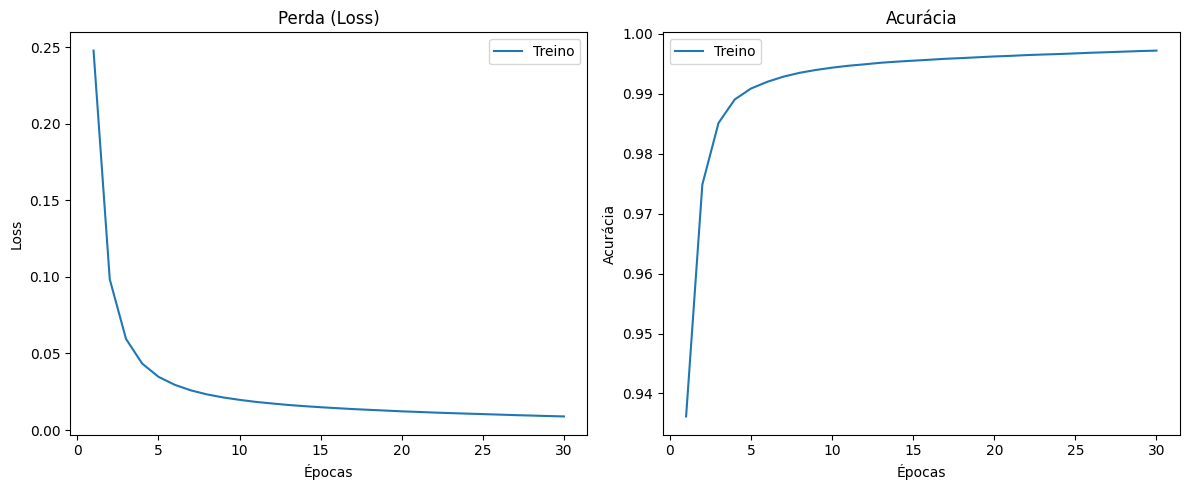

In [ ]:
import matplotlib.pyplot as plt

# Extrai os dados do histórico
hist = history.history
epochs = range(1, len(hist['loss']) + 1)

# 📉 Perda (loss)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, hist['loss'], label='Treino')
plt.title('Perda (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

# 📊 Acurácia (accuracy), se disponível
plt.subplot(1, 2, 2)
if 'accuracy' in hist:
    plt.plot(epochs, hist['accuracy'], label='Treino')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow.keras as keras

In [ ]:
model.save("bilstm_lstm.keras")

# Load model

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("bilstm_lstm.keras")

In [ ]:
model.compiled_metrics

<keras.src.backend.tensorflow.trainer.TensorFlowTrainer.compiled_metrics.<locals>.DeprecatedCompiledMetric at 0x7c757dee2e50>

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 249, 100)       │     3,302,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 249, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 249, 46)        │        11,822 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,647,056 (40.62 MB)

 Trainable params: 3,549,018 (13.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,098,038 (27.08 MB)

## Predict

In [ ]:
path = "/content/drive/MyDrive/Penn Treebank/Penn Treebank/Secs22-24 - testing" #Ju

In [ ]:
sentences_test = []
with open(path,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        sentences_test.extend(pt)

In [ ]:
sentences_dataset_spplited = []
with open(path,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        sentences_dataset_spplited.extend([pt])

# Simplify words for prediction | PREDICT TAGS com UNK WORDS

In [ ]:
def predict_tags(model, sentence, word2idx, idx2tag):
    word_ids = []
    for w in sentence:
        token = w[0].lower()
        if token in word2idx:
            word_ids.append(word2idx[token])
        else:
            simplified = simplify_word(token)
            word_ids.append(word2idx.get(simplified, word2idx['<UNK>']))

    padded = tf.keras.preprocessing.sequence.pad_sequences([word_ids], maxlen=max_len, padding='post')
    pred = model.predict(padded)[0]
    pred_tags = [idx2tag[np.argmax(p)] for p in pred[:len(sentence)]]
    return list(zip(sentence, pred_tags))


### Predict TAGS function

In [ ]:
import numpy as np

In [ ]:
def predict_tags(model, sentence, word2idx, idx2tag):
    word_ids = []
    for w in sentence:
        token = w[0].lower()
        if token in word2idx:
            word_ids.append(word2idx[token])
        else:
            simplified = simplify_word(token)
            word_ids.append(word2idx.get(simplified, word2idx['<UNK>']))

    padded = tf.keras.preprocessing.sequence.pad_sequences([word_ids], maxlen=max_len, padding='post')
    pred = model.predict(padded)[0]
    pred_tags = [idx2tag[np.argmax(p)] for p in pred[:len(sentence)]]
    return list(zip(sentence, pred_tags))


### Unknown words

In [ ]:
unk_count = sum(1 for sentence in sentences_dataset_spplited for w, _ in sentence if w.lower() not in word2idx)

count_per_sentence = []
count = 0
for s in sentences_dataset_spplited:
  cs = 0
  for w in s:
    count += 1
    cs += 1
  count_per_sentence.append(cs)
total = count

print(f"Unknown words: {unk_count}/{total} ({unk_count/total:.2%})")


Unknown words: 3240/129654 (2.50%)


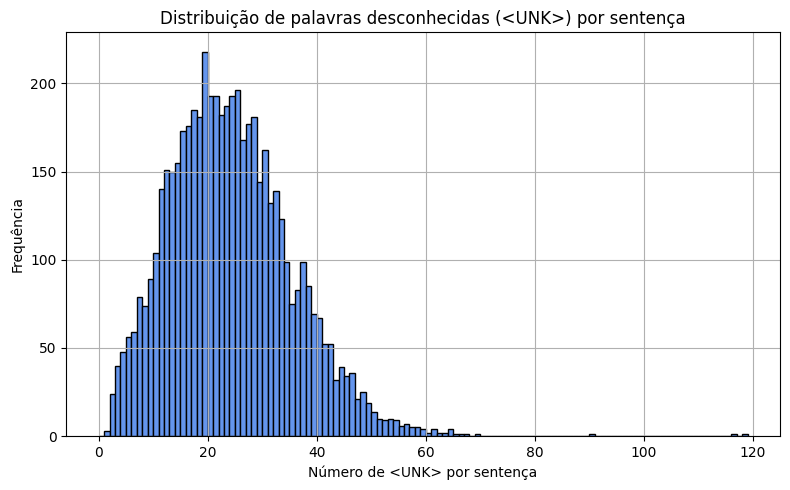

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(count_per_sentence, bins=range(0, max(count_per_sentence)+2), color='cornflowerblue', edgecolor='black')
plt.title('Distribuição de palavras desconhecidas (<UNK>) por sentença')
plt.xlabel('Número de <UNK> por sentença')
plt.ylabel('Frequência')
plt.grid(True)
plt.tight_layout()
plt.show()


# Prediction

Never run the cell bellow with all the sentences_text list. Because dataset's test has about 130k data.

In [ ]:
y_true = []
y_pred = []

for sentence in sentences_dataset_spplited[:5000]:  # Cada item é uma frase: [('The', 'DT'), ('cat', 'NN'), ...]
    true_tags = [tag for _, tag in sentence]
    predicted_tags = [tag for _, tag in predict_tags(model, sentence, word2idx, idx2tag)]

    y_true.extend(true_tags)
    y_pred.extend(predicted_tags)

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [ ]:
len(y_true)
len(y_pred)

117379

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

#print(classification_report(y_true, y_pred, digits=4))
print("Accuracy:", accuracy_score(y_true[:26758], y_pred[:26758]))
print("F1 macro:", f1_score(y_true[:26758], y_pred[:26758], average='macro'))


Accuracy: 0.945997458703939
F1 macro: 0.8634235842250604


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-43-1693723920.py:16: UserWarni

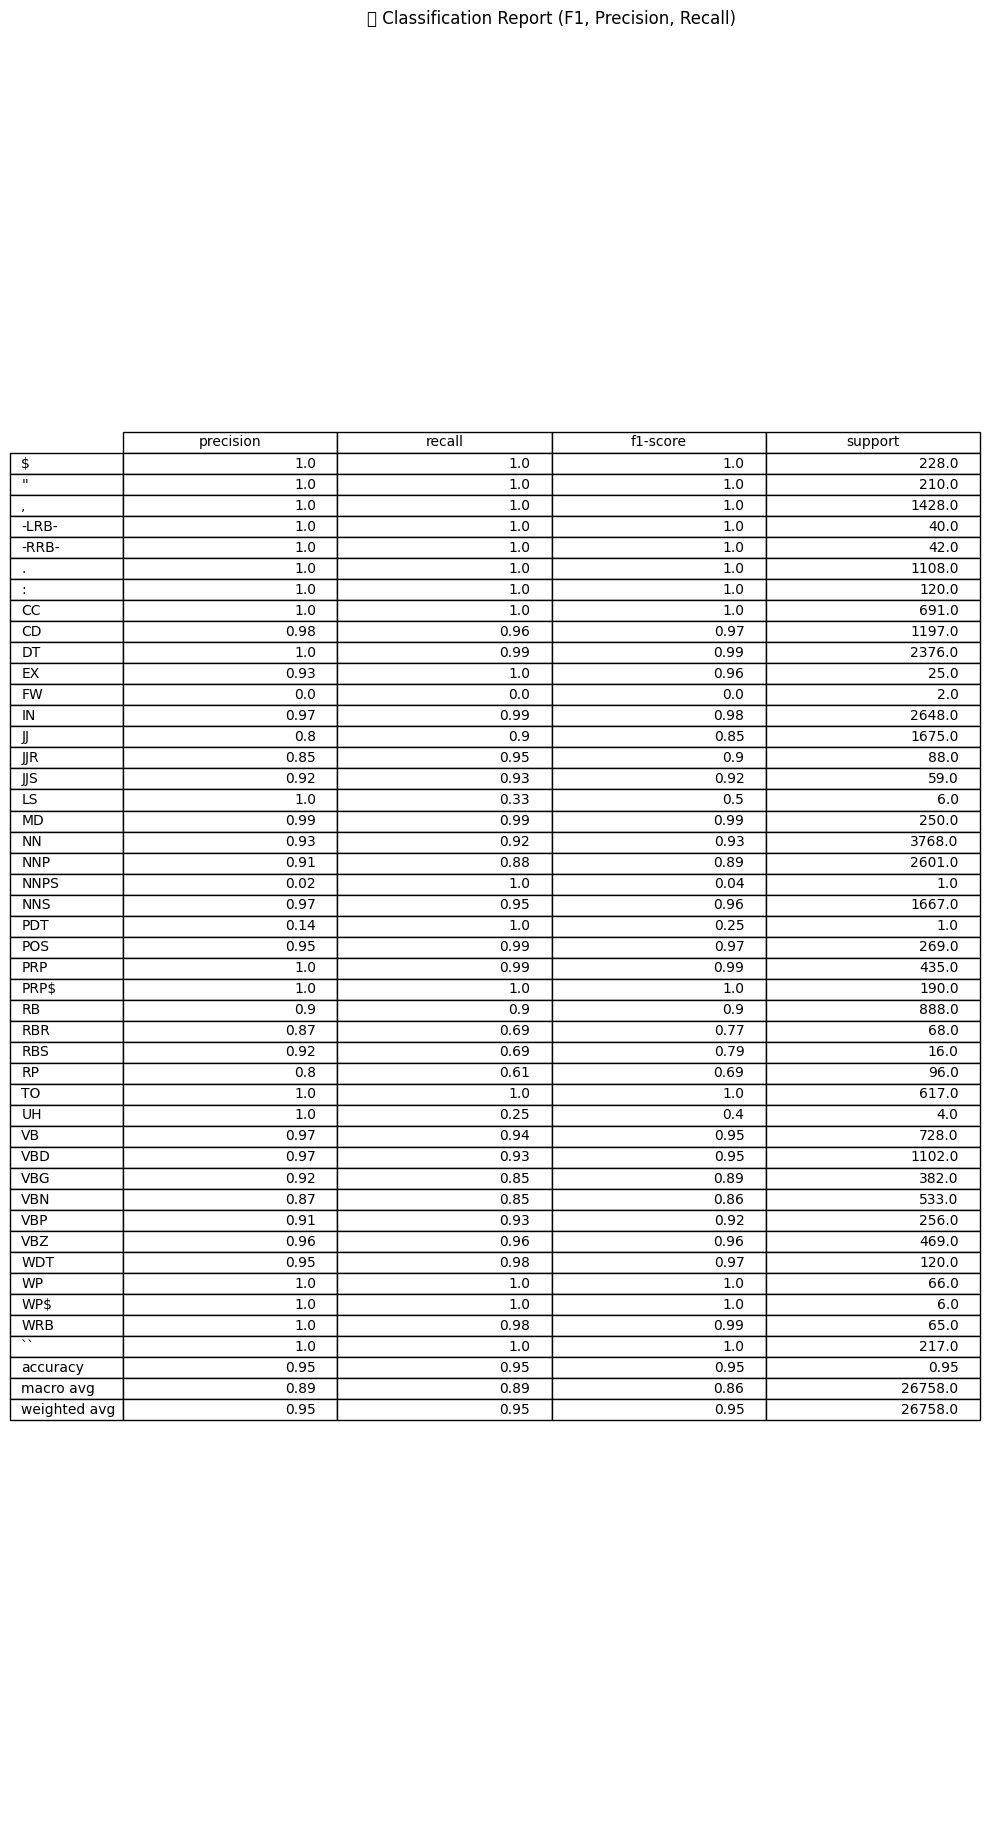

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd

report_dict = classification_report(y_true[:26758], y_pred[:26758], digits=4, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

fig, ax = plt.subplots(figsize=(10, len(df_report) * 0.4))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df_report.round(2).values,
         colLabels=df_report.columns,
         rowLabels=df_report.index,
         loc='center')
plt.title("📊 Classification Report (F1, Precision, Recall)")
plt.tight_layout()
plt.show()




/tmp/ipython-input-124-1207889945.py:7: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


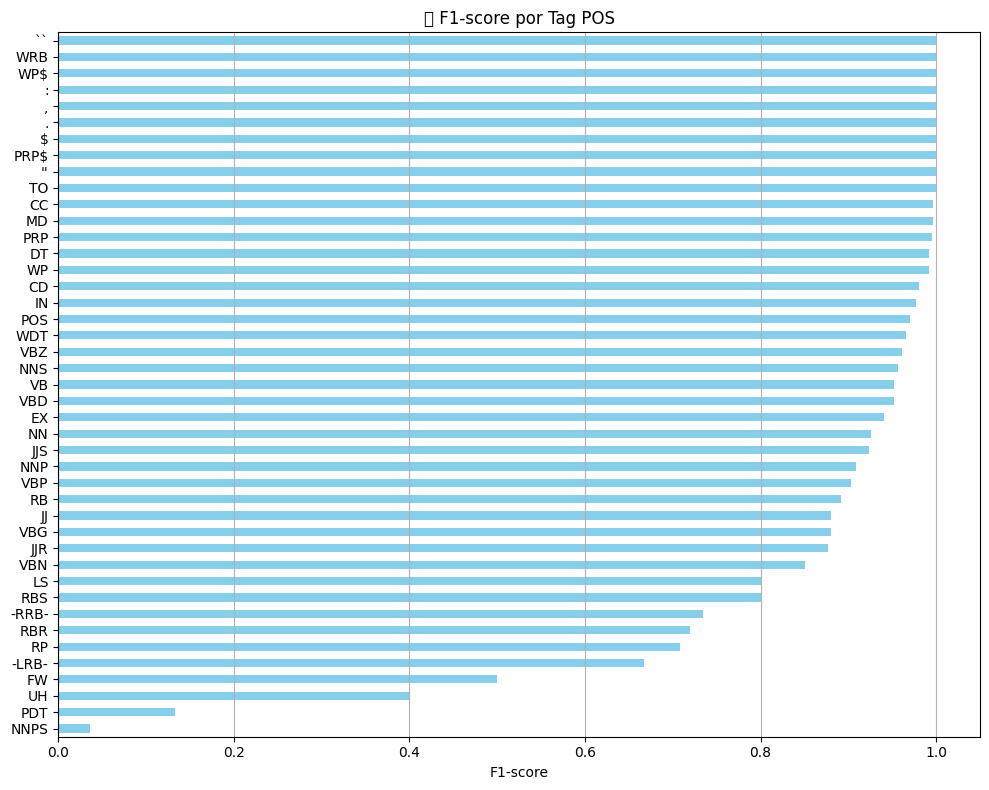

In [ ]:
f1_per_class = df_report.loc[df_report.index.str.len() <= 5].drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')['f1-score']

f1_per_class.sort_values().plot(kind='barh', figsize=(10, 8), color='skyblue')
plt.xlabel("F1-score")
plt.title("📌 F1-score por Tag POS")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt


/tmp/ipython-input-125-489268921.py:13: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


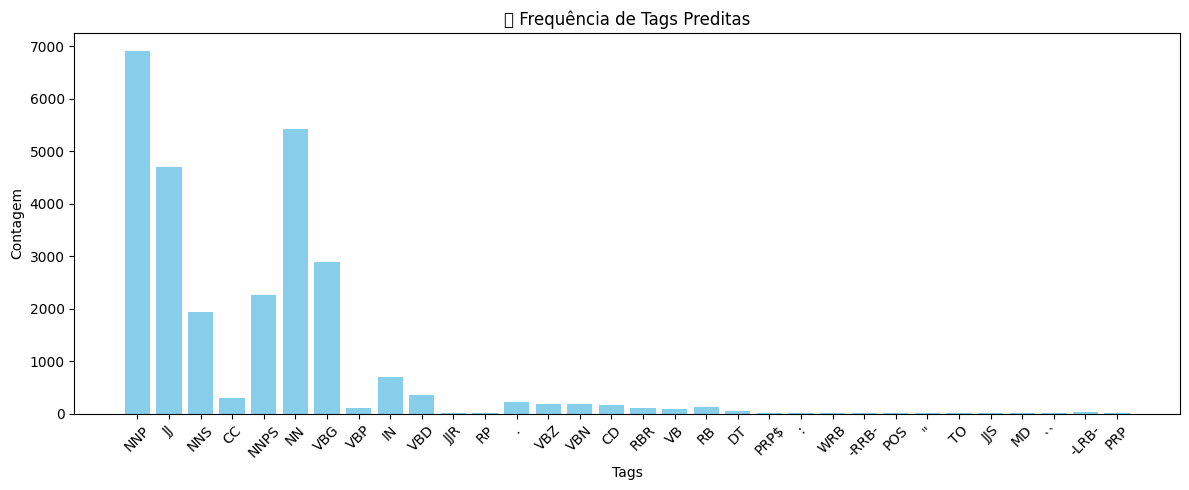

In [ ]:
from collections import Counter

# Conta as tags preditas
tag_counts = Counter(y_pred)

# Plota gráfico de barras
plt.figure(figsize=(12, 5))
plt.bar(tag_counts.keys(), tag_counts.values(), color='skyblue')
plt.title("📌 Frequência de Tags Preditas")
plt.xlabel("Tags")
plt.ylabel("Contagem")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-131-2000261160.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


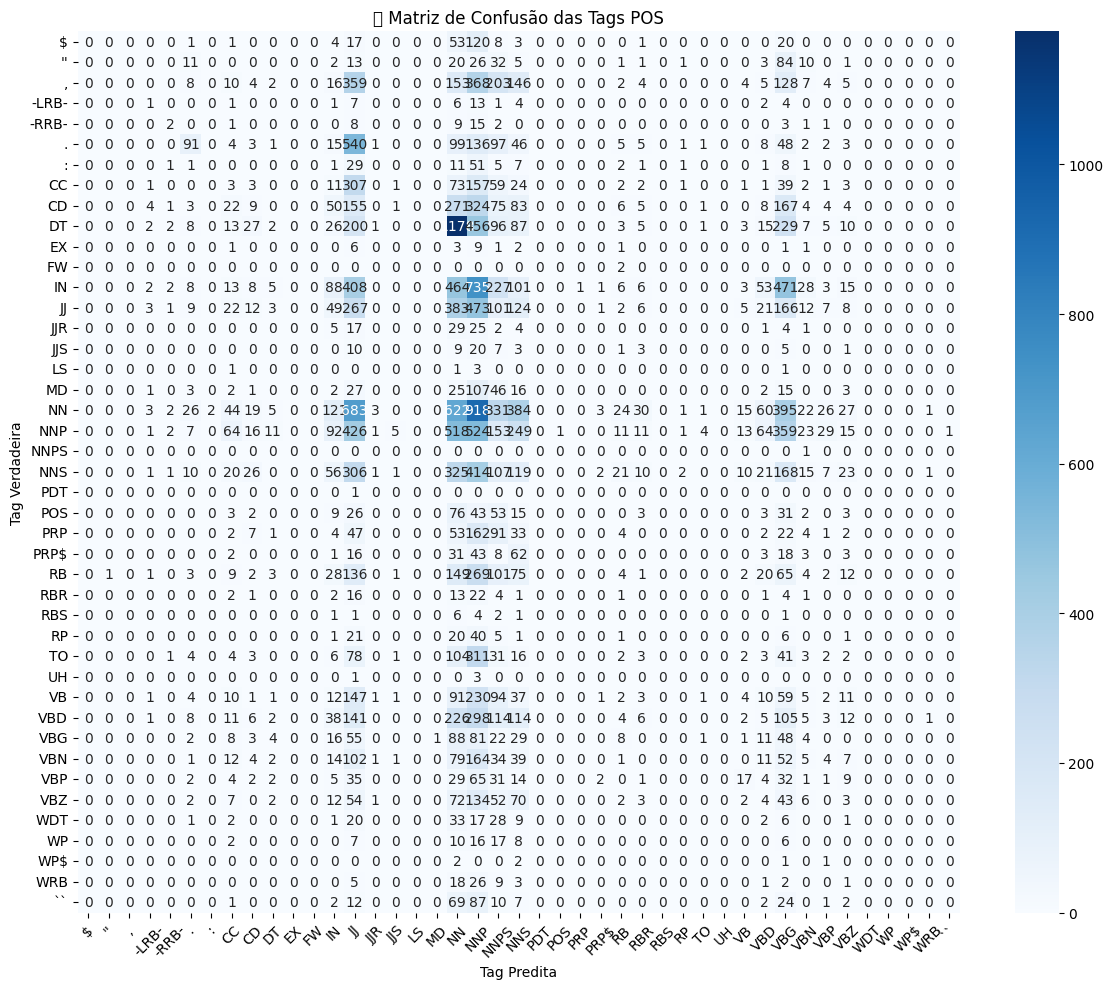

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Cria matriz de confusão
cm = confusion_matrix(y_true[:26758], y_pred[:26758], labels=sorted(set(y_true + y_pred)))

# Nomes das tags
labels = sorted(set(y_true + y_pred))

# Plot usando seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Tag Predita")
plt.ylabel("Tag Verdadeira")
plt.title("📊 Matriz de Confusão das Tags POS")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
